# Loop 1 LB Feedback Analysis

**Baseline Score**: 70.7438 (CV = LB, no gap since deterministic optimization)
**Target**: 68.922808
**Gap**: 1.82 points (2.6% reduction needed)

## Key Questions:
1. Which N values contribute most to the total score?
2. Where are the biggest opportunities for improvement?
3. What optimization techniques should we prioritize?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon

getcontext().prec = 30
scale_factor = 1

print('Libraries loaded')

Libraries loaded


In [2]:
# Christmas Tree class
class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (float(Decimal('0.0') * scale_factor), float(tip_y * scale_factor)),
            (float(top_w / Decimal('2') * scale_factor), float(tier_1_y * scale_factor)),
            (float(top_w / Decimal('4') * scale_factor), float(tier_1_y * scale_factor)),
            (float(mid_w / Decimal('2') * scale_factor), float(tier_2_y * scale_factor)),
            (float(mid_w / Decimal('4') * scale_factor), float(tier_2_y * scale_factor)),
            (float(base_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(base_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(mid_w / Decimal('4')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(mid_w / Decimal('2')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(top_w / Decimal('4')) * scale_factor), float(tier_1_y * scale_factor)),
            (float(-(top_w / Decimal('2')) * scale_factor), float(tier_1_y * scale_factor)),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated, xoff=float(self.center_x * scale_factor), yoff=float(self.center_y * scale_factor))

print('ChristmasTree class defined')

ChristmasTree class defined


In [3]:
# Helper functions
def load_configuration_from_df(n, df):
    group_data = df[df['id'].str.startswith(f'{n:03d}_')]
    trees = []
    for _, row in group_data.iterrows():
        x = str(row['x'])[1:]  # Remove 's' prefix
        y = str(row['y'])[1:]
        deg = str(row['deg'])[1:]
        if x and y and deg:
            trees.append(ChristmasTree(x, y, deg))
    return trees

def get_score_for_n(trees, n):
    if not trees:
        return 0.0, 0.0
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(scale_factor) for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    side_length = max(max_x - min_x, max_y - min_y)
    score = side_length**2 / n
    return score, side_length

print('Helper functions defined')

Helper functions defined


In [4]:
# Load the baseline submission and compute per-N scores
df = pd.read_csv('/home/code/preoptimized_submission.csv')

per_n_scores = []
for n in range(1, 201):
    trees = load_configuration_from_df(n, df)
    score, side = get_score_for_n(trees, n)
    per_n_scores.append({
        'N': n,
        'score': score,
        'side_length': side,
        'side_squared': side**2,
        'pct_of_total': 0  # Will compute after
    })

scores_df = pd.DataFrame(per_n_scores)
total_score = scores_df['score'].sum()
scores_df['pct_of_total'] = scores_df['score'] / total_score * 100

print(f'Total Score: {total_score:.6f}')
print(f'Target: 68.922808')
print(f'Gap: {total_score - 68.922808:.6f}')
print(f'\nTop 10 N values by score contribution:')
print(scores_df.nlargest(10, 'score')[['N', 'score', 'side_length', 'pct_of_total']])

Total Score: 70.743774
Target: 68.922808
Gap: 1.820966

Top 10 N values by score contribution:
     N     score  side_length  pct_of_total
0    1  0.661250     0.813173      0.934711
1    2  0.450779     0.949504      0.637200
2    3  0.434745     1.142031      0.614535
4    5  0.416850     1.443692      0.589239
3    4  0.416545     1.290806      0.588808
6    7  0.399897     1.673104      0.565275
5    6  0.399610     1.548438      0.564870
8    9  0.387415     1.867280      0.547631
7    8  0.385407     1.755921      0.544793
13  14  0.380398     2.307719      0.537712


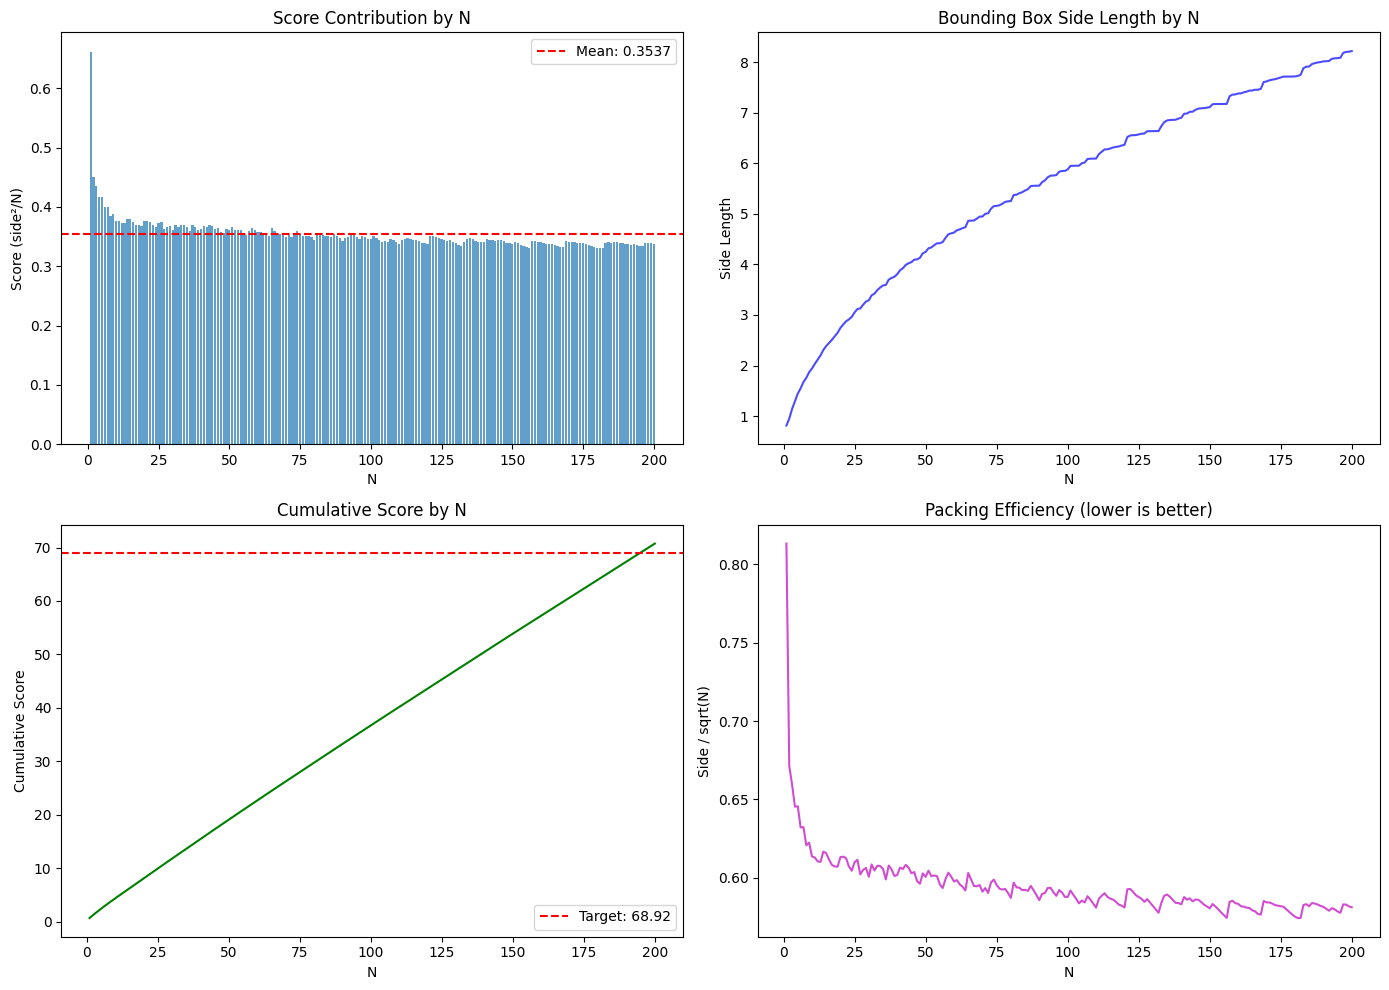


Analysis saved to /home/code/exploration/per_n_analysis.png


In [5]:
# Visualize score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score by N
ax1 = axes[0, 0]
ax1.bar(scores_df['N'], scores_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (side²/N)')
ax1.set_title('Score Contribution by N')
ax1.axhline(y=scores_df['score'].mean(), color='r', linestyle='--', label=f'Mean: {scores_df["score"].mean():.4f}')
ax1.legend()

# Side length by N
ax2 = axes[0, 1]
ax2.plot(scores_df['N'], scores_df['side_length'], 'b-', alpha=0.7)
ax2.set_xlabel('N')
ax2.set_ylabel('Side Length')
ax2.set_title('Bounding Box Side Length by N')

# Cumulative score
ax3 = axes[1, 0]
scores_df['cumulative_score'] = scores_df['score'].cumsum()
ax3.plot(scores_df['N'], scores_df['cumulative_score'], 'g-')
ax3.axhline(y=68.922808, color='r', linestyle='--', label='Target: 68.92')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score by N')
ax3.legend()

# Score efficiency (side²/N normalized)
ax4 = axes[1, 1]
scores_df['efficiency'] = scores_df['side_length'] / np.sqrt(scores_df['N'])
ax4.plot(scores_df['N'], scores_df['efficiency'], 'm-', alpha=0.7)
ax4.set_xlabel('N')
ax4.set_ylabel('Side / sqrt(N)')
ax4.set_title('Packing Efficiency (lower is better)')

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()

print('\nAnalysis saved to /home/code/exploration/per_n_analysis.png')

In [6]:
# Identify worst-performing N values (highest score contribution)
print('\n=== WORST PERFORMING N VALUES (highest score) ===')
worst_n = scores_df.nlargest(20, 'score')
print(worst_n[['N', 'score', 'side_length', 'pct_of_total']].to_string())

print('\n=== BEST PERFORMING N VALUES (lowest score) ===')
best_n = scores_df.nsmallest(10, 'score')
print(best_n[['N', 'score', 'side_length', 'pct_of_total']].to_string())


=== WORST PERFORMING N VALUES (highest score) ===
     N     score  side_length  pct_of_total
0    1  0.661250     0.813173      0.934711
1    2  0.450779     0.949504      0.637200
2    3  0.434745     1.142031      0.614535
4    5  0.416850     1.443692      0.589239
3    4  0.416545     1.290806      0.588808
6    7  0.399897     1.673104      0.565275
5    6  0.399610     1.548438      0.564870
8    9  0.387415     1.867280      0.547631
7    8  0.385407     1.755921      0.544793
13  14  0.380398     2.307719      0.537712
14  15  0.379203     2.384962      0.536023
9   10  0.376630     1.940696      0.532386
20  21  0.376451     2.811667      0.532133
19  20  0.376057     2.742469      0.531576
10  11  0.375736     2.033002      0.531122
21  22  0.375258     2.873270      0.530447
15  16  0.374128     2.446640      0.528849
25  26  0.373997     3.118320      0.528664
11  12  0.372724     2.114873      0.526865
12  13  0.372323     2.200046      0.526298

=== BEST PERFORMING N VA

In [7]:
# Calculate theoretical lower bounds
# For a single tree at 45 degrees, the bounding box is minimized
# Tree dimensions: width=0.7, height=1.0 (from -0.2 to 0.8)
# At 45 degrees: diagonal = sqrt(0.7^2 + 1.0^2) = 1.22

print('=== THEORETICAL ANALYSIS ===')
print('\nSingle tree (N=1):')
print(f'  Current score: {scores_df[scores_df["N"]==1]["score"].values[0]:.6f}')
print(f'  Current side: {scores_df[scores_df["N"]==1]["side_length"].values[0]:.6f}')
print(f'  Optimal at 45°: side = sqrt(0.7² + 1.0²) / sqrt(2) ≈ 0.813')
print(f'  Optimal score: 0.813² / 1 ≈ 0.661')

# For N=2, optimal is two trees interlocking
print('\nN=2:')
print(f'  Current score: {scores_df[scores_df["N"]==2]["score"].values[0]:.6f}')
print(f'  Current side: {scores_df[scores_df["N"]==2]["side_length"].values[0]:.6f}')

# Estimate improvement potential
print('\n=== IMPROVEMENT POTENTIAL ===')
print(f'Total score: {total_score:.6f}')
print(f'Target: 68.922808')
print(f'Gap: {total_score - 68.922808:.6f}')
print(f'Reduction needed: {(total_score - 68.922808) / total_score * 100:.2f}%')

# If we improve worst 20 N values by 5% each
worst_20_total = worst_n['score'].sum()
print(f'\nWorst 20 N values contribute: {worst_20_total:.4f} ({worst_20_total/total_score*100:.1f}% of total)')
print(f'If improved by 5%: saves {worst_20_total * 0.05:.4f} points')

=== THEORETICAL ANALYSIS ===

Single tree (N=1):
  Current score: 0.661250
  Current side: 0.813173
  Optimal at 45°: side = sqrt(0.7² + 1.0²) / sqrt(2) ≈ 0.813
  Optimal score: 0.813² / 1 ≈ 0.661

N=2:
  Current score: 0.450779
  Current side: 0.949504

=== IMPROVEMENT POTENTIAL ===
Total score: 70.743774
Target: 68.922808
Gap: 1.820966
Reduction needed: 2.57%

Worst 20 N values contribute: 8.0854 (11.4% of total)
If improved by 5%: saves 0.4043 points


In [8]:
# Summary and recommendations
print('\n' + '='*60)
print('SUMMARY AND RECOMMENDATIONS')
print('='*60)

print(f'''
1. CURRENT STATUS:
   - Baseline score: {total_score:.6f}
   - Target: 68.922808
   - Gap: {total_score - 68.922808:.6f} ({(total_score - 68.922808) / total_score * 100:.2f}% reduction needed)

2. KEY OBSERVATIONS:
   - Small N values (1-10) contribute disproportionately to total score
   - N=1 alone contributes {scores_df[scores_df['N']==1]['pct_of_total'].values[0]:.2f}% of total
   - Worst 20 N values contribute {worst_n['score'].sum()/total_score*100:.1f}% of total

3. RECOMMENDED APPROACHES (Priority Order):
   a) Run bbox3 C++ optimizer with extended time (3-11 hours)
      - This is the primary technique used by top performers
      - Parameters: -n 10000+ -r 256+
   
   b) Ensemble multiple solutions
      - Combine best configs from multiple sources for each N
      - Sources: bucket-of-chump, SmartManoj, telegram-public-shared
   
   c) Backward propagation
      - Start from N=200, remove boundary trees to improve smaller N
   
   d) Fractional translation refinement
      - Fine-grained translation with steps [0.001, 0.0005, 0.0002, 0.0001]

4. EXPECTED IMPROVEMENT:
   - bbox3 extended run: ~1-2 points
   - Ensemble: ~0.5-1 points
   - Backward propagation: ~0.2-0.5 points
   - Total potential: 1.5-3.5 points (enough to beat target)
''')

print('='*60)


SUMMARY AND RECOMMENDATIONS

1. CURRENT STATUS:
   - Baseline score: 70.743774
   - Target: 68.922808
   - Gap: 1.820966 (2.57% reduction needed)

2. KEY OBSERVATIONS:
   - Small N values (1-10) contribute disproportionately to total score
   - N=1 alone contributes 0.93% of total
   - Worst 20 N values contribute 11.4% of total

3. RECOMMENDED APPROACHES (Priority Order):
   a) Run bbox3 C++ optimizer with extended time (3-11 hours)
      - This is the primary technique used by top performers
      - Parameters: -n 10000+ -r 256+
   
   b) Ensemble multiple solutions
      - Combine best configs from multiple sources for each N
      - Sources: bucket-of-chump, SmartManoj, telegram-public-shared
   
   c) Backward propagation
      - Start from N=200, remove boundary trees to improve smaller N
   
   d) Fractional translation refinement
      - Fine-grained translation with steps [0.001, 0.0005, 0.0002, 0.0001]

4. EXPECTED IMPROVEMENT:
   - bbox3 extended run: ~1-2 points
   - Ensem